In [1]:
import cdsapi
import atlite   
import geopandas as gpd
from shapely import wkt
import cartopy.io.shapereader as shpreader
from datetime import timedelta
import xarray as xr
import pandas as pd 
import matplotlib.pyplot as plt
from shapely import LineString, MultiPoint, Polygon


In [10]:
gpd_data = gpd.read_file('test.csv')
gpd_data['geometry'] = gpd_data['geometry'].apply(wkt.loads)
gpd_data = gpd_data.set_geometry('geometry')
gpd_data = gpd_data.set_crs(epsg=4326)

gpd_data['center'] = gpd_data['geometry'].centroid
gpd_data = gpd_data.set_geometry('center')
gpd_data = gpd_data.drop(columns='geometry')
gpd_data['x'] = gpd_data.geometry.x
gpd_data['y'] = gpd_data.geometry.y
gpd_data = gpd_data.drop(columns='center')
gpd_data = gpd_data.set_index('name')
print(gpd_data)

               x         y
name                      
P1    100.161111  7.197222
P2    100.494444  7.263889


/var/folders/rx/tstwq_0j2fs2k5dh4m8xnhdc0000gn/T/ipykernel_11597/1422449621.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd_data['center'] = gpd_data['geometry'].centroid


In [11]:
shpfilename = shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )
reader = shpreader.Reader(shpfilename)
th = gpd.GeoSeries(
        {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
        crs={"init": "epsg:4326"},
    ).reindex(["Thailand"])
print(th)
bounds = th.unary_union.bounds
print(bounds)


Thailand    MULTIPOLYGON (((102.91358 11.6459, 102.90602 1...
dtype: geometry
(97.35140100100011, 5.629890035000059, 105.65099776200003, 20.44500640900013)


/Users/narasetsinsang/workstation/generationprofile_solarwind/env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/rx/tstwq_0j2fs2k5dh4m8xnhdc0000gn/T/ipykernel_11597/2501923792.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = th.unary_union.bounds


/var/folders/rx/tstwq_0j2fs2k5dh4m8xnhdc0000gn/T/ipykernel_11597/3915123583.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds= th.unary_union.bounds,
/Users/narasetsinsang/workstation/generationprofile_solarwind/env/lib/python3.11/site-packages/atlite/cutout.py:191: UserWarning: Arguments module, bounds, time, dt, dx, dy are ignored, since cutout is already built.
  warn(


test_2016.nc


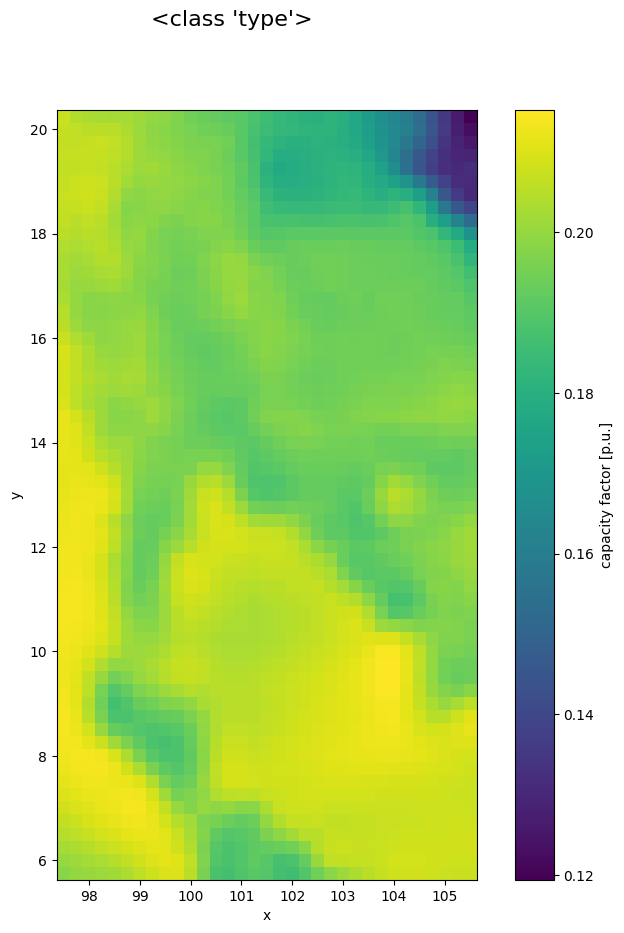

In [12]:
    ##### offset date #####
year = 2016
utc = 7
datestart = str(year-1) + '-12-31'
dateend = str(year) + '-01-1'

path = 'CDS_Data/test_' + str(year) + ".nc"
print(path)
cutout = atlite.Cutout(
        path=path,
        module="era5",
        bounds= th.unary_union.bounds,
        # time= slice('2002-12-31','2003-01-02'),
        time= slice(datestart,dateend),
        dt = 'h',
        dx = 0.01, 
        dy = 0.01,
    )
    # This is where all the work happens (this can take some time, for us it took ~15 minutes).
cutout.prepare(['height','influx', 'temperature'])
cap_fac = cutout.pv(    
                panel="CSi",
                orientation="latitude_optimal",
                capacity_factor=True,
                tracking= None,
            )
layout = xr.DataArray(1,coords= cap_fac.coords)

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(str(type), fontsize=16)
th.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
cap_fac.plot(ax = ax, zorder = 1)


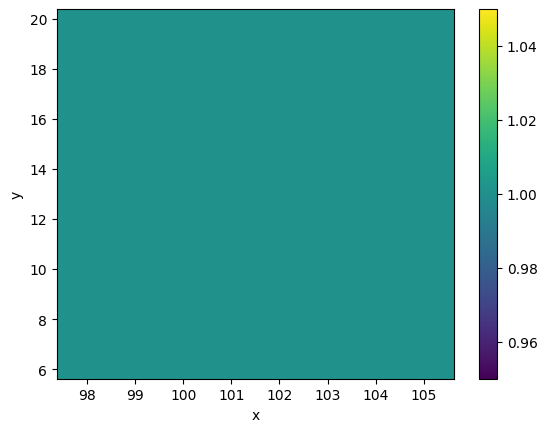

In [13]:
layout.plot()

         x     y                                           geometry
P1  100.25  7.25  POLYGON ((100.375 7.125, 100.375 7.375, 100.12...
P2  100.50  7.25  POLYGON ((100.625 7.125, 100.625 7.375, 100.37...
<xarray.DataArray 'specific generation' (time: 2928, dim_0: 2)> Size: 47kB
array([[0.        , 0.        ],
       [0.12096181, 0.11570035],
       [0.30259243, 0.28963752],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])
Coordinates:
  * time     (time) datetime64[ns] 23kB 2015-12-31 ... 2016-04-30T23:00:00
  * dim_0    (dim_0) object 16B 'P1' 'P2'
Attributes:
    units:    MW
dim_0                      P1        P2
time                                   
2015-12-31 00:00:00  0.000000  0.000000
2015-12-31 01:00:00  0.120962  0.115700
2015-12-31 02:00:00  0.302592  0.289638
2015-12-31 03:00:00  0.386557  0.391680
2015-12-31 04:00:00  0.471590  0.459775
...                       ...       ...
2016-04-30 19:00:00  0.000000  

<Axes: xlabel='time'>

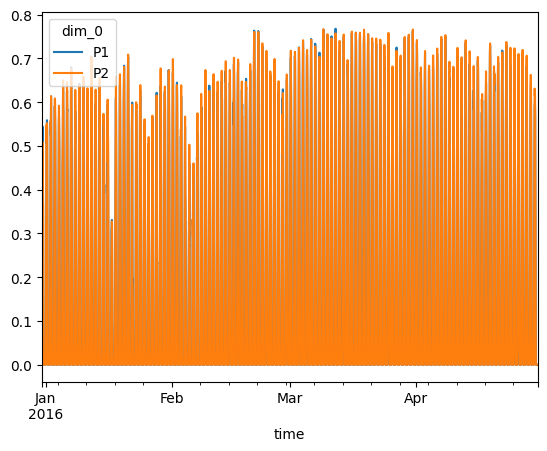

In [15]:
# gpd_data = gpd.GeoDataFrame(
#     [
#         ["P1", 11, 97.8],
#         ["P2", 10.5, 98],
#         ["P3", 11.2, 97.5],
#     ],
#     columns=["name", "y", "x"],
# ).set_index("name")

cells = cutout.grid
nearest = cutout.data.sel({"x": gpd_data.x.values, "y": gpd_data.y.values}, "nearest").coords
gpd_data["x"] = nearest.get("x").values
gpd_data["y"] = nearest.get("y").values
cells_generation = gpd_data.merge(cells, how="inner").rename(pd.Series(gpd_data.index))
print(cells_generation)

power_generation = cutout.pv(    
                panel="CSi",
                orientation="latitude_optimal",
                capacity_factor=True,
                tracking= None,
                # shapes = th.geometry,
                # shapes= gpd_data.geometry,
                shapes= cells_generation.geometry
            ) 

print(power_generation)
output = power_generation.to_pandas()
print(output)
output.plot()